In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch
import torchvision
import torch.nn.functional as F
from torch import Tensor, nn
#from torchsummary import summary
from torchvision.transforms import Compose, Resize, ToTensor

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

In [3]:
# Check the versions of torch and torchvision
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

# Check the available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Available device: {device}")

torch version: 2.5.1+cu118
torchvision version: 0.20.1
Available device: cuda


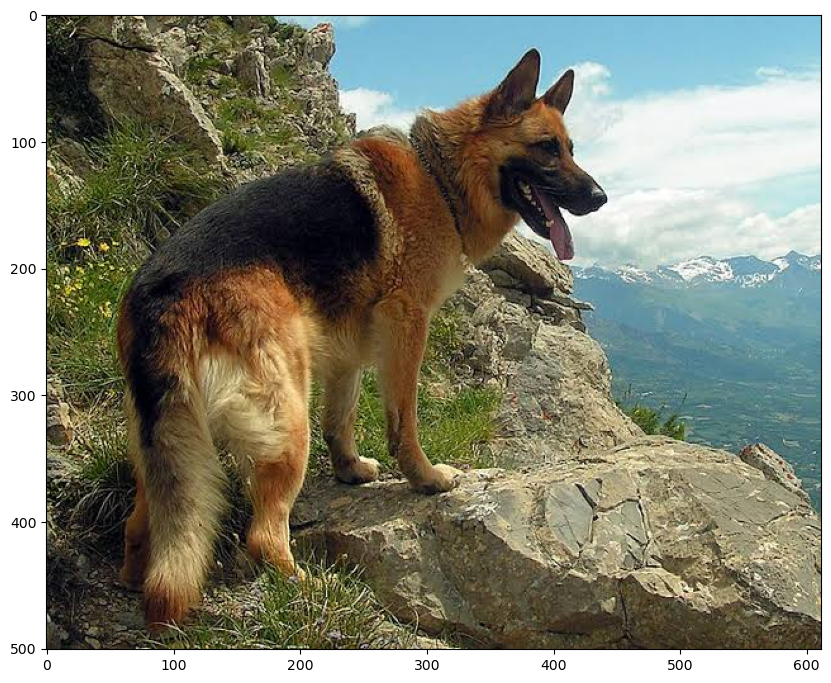

torch.Size([1, 3, 28, 28])


<Figure size 640x480 with 0 Axes>

In [4]:
img = Image.open('Images/dog.jpeg')

fig = plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()
plt.tight_layout()

transform = Compose([
    Resize((28, 28)),
    ToTensor(),
])
img = transform(img).unsqueeze(0)
print(img.shape)


In [14]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        super().__init__()
        self.patch_size = patch_size
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )

        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) ** 2 + 1, emb_size)) 

    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positions
        return x
    

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x: Tensor, mask: Tensor = None) -> Tensor:
        b, n, _ = x.shape
        qkv = rearrange(self.qkv(x), 'b n (h d qkv) -> (qkv) b h n d', qkv=3, h=self.num_heads)
        q, k, v = qkv[0], qkv[1], qkv[2]

        dots = torch.einsum('bhqd,bhkd->bhqk', q, k) # Batch, Head, Query, Key
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            dots.masked_fill_(mask, fill_value)

        scaling = self.emb_size ** (1/2)

        attn = F.softmax(dots, dim=-1) / scaling
        attn = self.att_drop(attn)
        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.projection(out)
    

class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return x + self.fn(x, **kwargs)
    

class FeedForwardBlock(nn.Module):
    def __init__(self, emb_size: int = 768, expansion: int = 4, drop_p: float = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

    def forward(self, x):
        return self.net(x)
    

class TransformerEncoderBlock(nn.Sequential):
    def __init__(self, emb_size: int = 768, drop_p: float = 0., forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 **kwargs):
                 
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))
    

class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super(TransformerEncoder, self).__init__(
            *[TransformerEncoderBlock(**kwargs) for _ in range(depth)]
        )


class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 10):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))
    

class ViT(nn.Sequential):
    def __init__(self, in_channels: int = 3, 
                 patch_size: int = 16, 
                 emb_size: int = 768, 
                 img_size: int = 28, 
                 depth: int = 1, 
                 num_classes: int = 1000, 
                 **kwargs):
        super(ViT, self).__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, num_classes)
        )

In [15]:
print(summary(ViT(), (3, 28, 28), device='cpu'))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 768, 1, 1]         590,592
         Rearrange-2               [-1, 1, 768]               0
    PatchEmbedding-3               [-1, 2, 768]               0
         LayerNorm-4               [-1, 2, 768]           1,536
            Linear-5              [-1, 2, 2304]       1,771,776
           Dropout-6              [-1, 8, 2, 2]               0
            Linear-7               [-1, 2, 768]         590,592
MultiHeadAttention-8               [-1, 2, 768]               0
           Dropout-9               [-1, 2, 768]               0
      ResidualAdd-10               [-1, 2, 768]               0
        LayerNorm-11               [-1, 2, 768]           1,536
           Linear-12              [-1, 2, 3072]       2,362,368
             GELU-13              [-1, 2, 3072]               0
          Dropout-14              [-1, 

In [16]:
# Initialize the ViT model
vit_model = ViT(num_classes=10)

# Pass the image tensor through the model
output = vit_model(img)

# Print the output
print(output.shape)

torch.Size([1, 10])


Files already downloaded and verified
Files already downloaded and verified


Epoch 1/50: 100%|██████████| 782/782 [00:22<00:00, 34.52it/s]


Epoch 1, Train Loss: 1.8774, Val Loss: 1.7186, Val Acc: 37.81%
Checkpoint saved: Best Val Acc = 37.81%


Epoch 2/50: 100%|██████████| 782/782 [00:20<00:00, 37.91it/s]


Epoch 2, Train Loss: 1.7014, Val Loss: 1.6808, Val Acc: 40.02%
Checkpoint saved: Best Val Acc = 40.02%


Epoch 3/50: 100%|██████████| 782/782 [00:20<00:00, 37.88it/s]


Epoch 3, Train Loss: 1.6329, Val Loss: 1.6242, Val Acc: 40.56%
Checkpoint saved: Best Val Acc = 40.56%


Epoch 4/50: 100%|██████████| 782/782 [00:20<00:00, 37.60it/s]


Epoch 4, Train Loss: 1.6078, Val Loss: 1.5810, Val Acc: 43.83%
Checkpoint saved: Best Val Acc = 43.83%


Epoch 5/50: 100%|██████████| 782/782 [00:20<00:00, 37.71it/s]


Epoch 5, Train Loss: 1.5790, Val Loss: 1.6245, Val Acc: 40.36%


Epoch 6/50: 100%|██████████| 782/782 [00:20<00:00, 37.56it/s]


Epoch 6, Train Loss: 1.5526, Val Loss: 1.5793, Val Acc: 42.51%


Epoch 7/50: 100%|██████████| 782/782 [00:20<00:00, 37.84it/s]


Epoch 7, Train Loss: 1.5349, Val Loss: 1.5466, Val Acc: 45.13%
Checkpoint saved: Best Val Acc = 45.13%


Epoch 8/50: 100%|██████████| 782/782 [00:20<00:00, 37.66it/s]


Epoch 8, Train Loss: 1.5096, Val Loss: 1.5362, Val Acc: 45.13%


Epoch 9/50: 100%|██████████| 782/782 [00:20<00:00, 37.55it/s]


Epoch 9, Train Loss: 1.4942, Val Loss: 1.5334, Val Acc: 44.99%


Epoch 10/50: 100%|██████████| 782/782 [00:20<00:00, 37.77it/s]


Epoch 10, Train Loss: 1.4705, Val Loss: 1.5068, Val Acc: 45.94%
Checkpoint saved: Best Val Acc = 45.94%


Epoch 11/50: 100%|██████████| 782/782 [00:20<00:00, 37.65it/s]


Epoch 11, Train Loss: 1.4485, Val Loss: 1.4885, Val Acc: 46.61%
Checkpoint saved: Best Val Acc = 46.61%


Epoch 12/50: 100%|██████████| 782/782 [00:20<00:00, 37.30it/s]


Epoch 12, Train Loss: 1.4331, Val Loss: 1.4858, Val Acc: 47.26%
Checkpoint saved: Best Val Acc = 47.26%


Epoch 13/50: 100%|██████████| 782/782 [00:20<00:00, 37.39it/s]


Epoch 13, Train Loss: 1.4200, Val Loss: 1.4917, Val Acc: 46.39%


Epoch 14/50: 100%|██████████| 782/782 [00:20<00:00, 37.29it/s]


Epoch 14, Train Loss: 1.4013, Val Loss: 1.4736, Val Acc: 48.02%
Checkpoint saved: Best Val Acc = 48.02%


Epoch 15/50: 100%|██████████| 782/782 [00:20<00:00, 37.40it/s]


Epoch 15, Train Loss: 1.3848, Val Loss: 1.4847, Val Acc: 47.17%


Epoch 16/50: 100%|██████████| 782/782 [00:20<00:00, 37.63it/s]


Epoch 16, Train Loss: 1.3828, Val Loss: 1.4770, Val Acc: 47.27%


Epoch 17/50: 100%|██████████| 782/782 [00:20<00:00, 37.48it/s]


Epoch 17, Train Loss: 1.3678, Val Loss: 1.4486, Val Acc: 48.91%
Checkpoint saved: Best Val Acc = 48.91%


Epoch 18/50: 100%|██████████| 782/782 [00:21<00:00, 37.21it/s]


Epoch 18, Train Loss: 1.3373, Val Loss: 1.4608, Val Acc: 48.37%


Epoch 19/50: 100%|██████████| 782/782 [00:20<00:00, 37.52it/s]


Epoch 19, Train Loss: 1.3296, Val Loss: 1.4534, Val Acc: 48.68%


Epoch 20/50: 100%|██████████| 782/782 [00:20<00:00, 37.58it/s]


Epoch 20, Train Loss: 1.3147, Val Loss: 1.4676, Val Acc: 48.50%


Epoch 21/50: 100%|██████████| 782/782 [00:20<00:00, 37.27it/s]


Epoch 21, Train Loss: 1.2917, Val Loss: 1.4615, Val Acc: 48.69%


Epoch 22/50: 100%|██████████| 782/782 [00:20<00:00, 37.55it/s]


Epoch 22, Train Loss: 1.2799, Val Loss: 1.4488, Val Acc: 49.09%
Checkpoint saved: Best Val Acc = 49.09%


Epoch 23/50: 100%|██████████| 782/782 [00:21<00:00, 37.11it/s]


Epoch 23, Train Loss: 1.2592, Val Loss: 1.4507, Val Acc: 49.38%
Checkpoint saved: Best Val Acc = 49.38%


Epoch 24/50: 100%|██████████| 782/782 [00:20<00:00, 37.28it/s]


Epoch 24, Train Loss: 1.2467, Val Loss: 1.4386, Val Acc: 49.07%


Epoch 25/50: 100%|██████████| 782/782 [00:20<00:00, 37.46it/s]


Epoch 25, Train Loss: 1.2230, Val Loss: 1.4671, Val Acc: 48.88%


Epoch 26/50: 100%|██████████| 782/782 [00:20<00:00, 37.44it/s]


Epoch 26, Train Loss: 1.2056, Val Loss: 1.4768, Val Acc: 49.16%


Epoch 27/50: 100%|██████████| 782/782 [00:20<00:00, 37.28it/s]


Epoch 27, Train Loss: 1.1946, Val Loss: 1.4615, Val Acc: 49.06%


Epoch 28/50: 100%|██████████| 782/782 [00:20<00:00, 37.69it/s]


Epoch 28, Train Loss: 1.1691, Val Loss: 1.4812, Val Acc: 49.08%


Epoch 29/50: 100%|██████████| 782/782 [00:20<00:00, 37.62it/s]


Epoch 29, Train Loss: 1.1546, Val Loss: 1.4682, Val Acc: 49.41%
Checkpoint saved: Best Val Acc = 49.41%


Epoch 30/50: 100%|██████████| 782/782 [00:20<00:00, 37.30it/s]


Epoch 30, Train Loss: 1.1344, Val Loss: 1.4837, Val Acc: 49.63%
Checkpoint saved: Best Val Acc = 49.63%


Epoch 31/50: 100%|██████████| 782/782 [00:20<00:00, 37.32it/s]


Epoch 31, Train Loss: 1.1138, Val Loss: 1.4666, Val Acc: 50.14%
Checkpoint saved: Best Val Acc = 50.14%


Epoch 32/50: 100%|██████████| 782/782 [00:20<00:00, 37.64it/s]


Epoch 32, Train Loss: 1.0892, Val Loss: 1.4973, Val Acc: 49.58%


Epoch 33/50: 100%|██████████| 782/782 [00:21<00:00, 36.23it/s]


Epoch 33, Train Loss: 1.0750, Val Loss: 1.5144, Val Acc: 49.41%


Epoch 34/50: 100%|██████████| 782/782 [00:22<00:00, 34.92it/s]


Epoch 34, Train Loss: 1.0524, Val Loss: 1.5347, Val Acc: 48.87%


Epoch 35/50: 100%|██████████| 782/782 [00:22<00:00, 34.81it/s]


Epoch 35, Train Loss: 1.0342, Val Loss: 1.5465, Val Acc: 48.90%


Epoch 36/50: 100%|██████████| 782/782 [00:22<00:00, 34.58it/s]


Epoch 36, Train Loss: 1.0100, Val Loss: 1.5545, Val Acc: 49.05%


Epoch 37/50: 100%|██████████| 782/782 [00:22<00:00, 34.83it/s]


Epoch 37, Train Loss: 0.9910, Val Loss: 1.5362, Val Acc: 50.42%
Checkpoint saved: Best Val Acc = 50.42%


Epoch 38/50: 100%|██████████| 782/782 [00:22<00:00, 34.68it/s]


Epoch 38, Train Loss: 0.9762, Val Loss: 1.5446, Val Acc: 49.66%


Epoch 39/50: 100%|██████████| 782/782 [00:22<00:00, 35.12it/s]


Epoch 39, Train Loss: 0.9497, Val Loss: 1.5860, Val Acc: 49.18%


Epoch 40/50: 100%|██████████| 782/782 [00:22<00:00, 35.18it/s]


Epoch 40, Train Loss: 0.9298, Val Loss: 1.6145, Val Acc: 49.13%


Epoch 41/50: 100%|██████████| 782/782 [00:22<00:00, 35.15it/s]


Epoch 41, Train Loss: 0.9141, Val Loss: 1.6152, Val Acc: 49.58%


Epoch 42/50: 100%|██████████| 782/782 [00:22<00:00, 34.71it/s]


Epoch 42, Train Loss: 0.8999, Val Loss: 1.6306, Val Acc: 49.96%


Epoch 43/50: 100%|██████████| 782/782 [00:22<00:00, 34.83it/s]


Epoch 43, Train Loss: 0.8749, Val Loss: 1.6530, Val Acc: 48.84%


Epoch 44/50: 100%|██████████| 782/782 [00:22<00:00, 34.79it/s]


Epoch 44, Train Loss: 0.8562, Val Loss: 1.6904, Val Acc: 49.02%


Epoch 45/50: 100%|██████████| 782/782 [00:22<00:00, 35.35it/s]


Epoch 45, Train Loss: 0.8343, Val Loss: 1.6738, Val Acc: 48.80%


Epoch 46/50: 100%|██████████| 782/782 [00:22<00:00, 35.16it/s]


Epoch 46, Train Loss: 0.8138, Val Loss: 1.7541, Val Acc: 48.17%


Epoch 47/50: 100%|██████████| 782/782 [00:22<00:00, 35.07it/s]


Epoch 47, Train Loss: 0.7963, Val Loss: 1.7867, Val Acc: 47.45%


Epoch 48/50: 100%|██████████| 782/782 [00:22<00:00, 35.20it/s]


Epoch 48, Train Loss: 0.7850, Val Loss: 1.8160, Val Acc: 47.66%


Epoch 49/50: 100%|██████████| 782/782 [00:22<00:00, 35.11it/s]


Epoch 49, Train Loss: 0.7644, Val Loss: 1.7870, Val Acc: 48.24%


Epoch 50/50: 100%|██████████| 782/782 [00:22<00:00, 35.24it/s]


Epoch 50, Train Loss: 0.7471, Val Loss: 1.8421, Val Acc: 48.42%
Finished Training


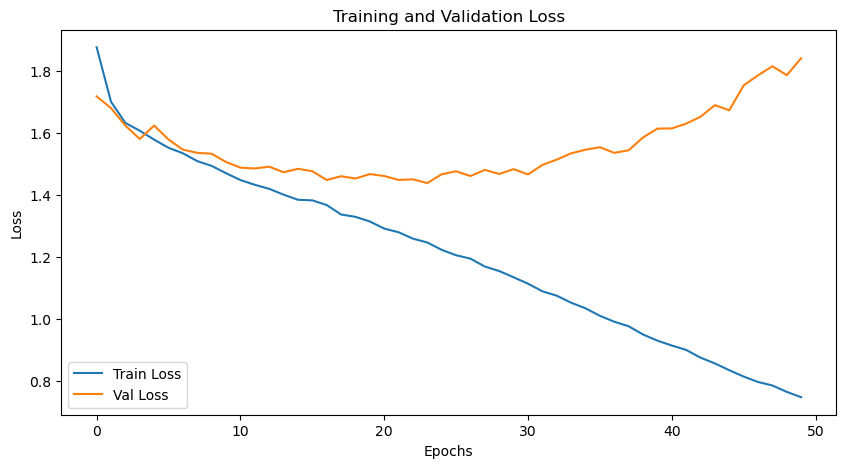

In [17]:
import torchvision
from torch.utils.data import DataLoader, Subset

import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm

def train_vit_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, save_path='model.pth'):
    model.to(device)

    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}')):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validate the model
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Compute the accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        history['val_loss'].append(avg_val_loss)

        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save the best model (fixing the incorrect checkpoint saving condition)
        if val_acc > best_val_acc:
            best_val_acc = val_acc  # Update the best validation accuracy
            torch.save({'epoch': epoch + 1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'best_val_acc': best_val_acc}, save_path)
            print(f"Checkpoint saved: Best Val Acc = {best_val_acc:.2f}%")

    print('Finished Training')

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Define transformations for the training set
transform_train = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load the CIFAR-10 training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

# # Subset the training and validation set
# num_trainingsamples = int(0.1 * len(trainset))
# num_valsamples = int(0.1 * len(valset))

# train_idx = torch.randperm(len(trainset))[:num_trainingsamples]
# val_idx = torch.randperm(len(valset))[:num_valsamples]

# train_subset = Subset(trainset, train_idx)
# val_subset = Subset(valset, val_idx)
# #trainloader = DataLoader(train_subset, batch_size=64, shuffle=True)
# #valloader = DataLoader(val_subset, batch_size=64, shuffle=False)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=0.001, weight_decay=0.00001)

# Train the model
checkpoint_path = 'checkpoints/vit_model_1.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_vit_model(vit_model, trainloader, valloader, criterion, optimizer, device, num_epochs=50, save_path=checkpoint_path)